delta_nu/2 instead of delta_nu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from NEID_solar_functions import *
from GP_kernels import *


In [2]:
SONG = np.loadtxt('sun_SONG_full_lowess_filtered_final_used.dat')
bjd = SONG[:,0]
rv = SONG[:,1]

In [3]:
start_date = datetime(2018, 5, 27)
end_date = datetime(2018, 5, 27)

for date in daterange(start_date, end_date):
    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1)
    
    t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
    y = rv[idx_bjd]
    yerr = np.ones(len(t))*0.7
    

    
    gp = GP_fit_p1(t, y, yerr, p=5.37)
    t = np.linspace(min(t), max(t), 3000)
    y, yerr = gp.predict(y, t, return_var=True)
    
    t0 = t
    y0 = y
    yerr0 = yerr    

In [4]:
idx_test = ((t > 450) & (t < 550))
t = t[~idx_test]
y = y[~idx_test]
yerr = yerr[~idx_test]

In [5]:
# idx = np.sort(random.sample(range(0, len(t)), 3000))

In [6]:
# t = t[idx] - min(t[idx])
# y = y[idx]
# yerr = yerr[idx]

In [7]:
# plt.rcParams.update({'font.size': 18})
# fig = plt.figure(figsize=(10, 6))
# plt.plot(t, y, '.')

In [8]:
import jax
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
import tinygp

jax.config.update("jax_enable_x64", True)


2022-11-09 13:38:30.326567: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2022-11-09 13:38:30.558793: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2022-11-09 13:38:30.568932: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/jul

In [9]:
# Factor to convert uHz to minute^-1
uHz_conv = 1e-6 * 60

def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    A = jnp.exp(theta["log_A"])
    W = jnp.exp(theta["log_W"])
    # sigma = jnp.exp(theta["log_sigma"])
    nu_max = jnp.exp(theta["log_nu_max"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    epsilon = theta["epsilon"]

    # Construct the kernel by multiplying and adding `Kernel` objects
    
    kernel = 0     
    N = 19 # 25*135/2=1620
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = A*jnp.exp( - (i*delta_nu/2 + epsilon)**2 / (2*W**2) ) # uHz_conv is cancelled out; change A/Q**2 to A**2
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]))    

def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "log_diag": np.log(0.7),
    "log_Q": np.log(500),
    "log_A": np.log(0.35),
    "log_W": np.log(300),
    "log_nu_max": np.log(3080),
    "log_delta_nu": np.log(135),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

2022-11-09 13:38:31.400656: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2022-11-09 13:38:31.400692: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Initial negative log likelihood: 2717.6046189140125
Gradient of the negative log likelihood, wrt the parameters:
{'epsilon': DeviceArray(-7.10257461, dtype=float64), 'log_A': DeviceArray(-170.38714484, dtype=float64), 'log_Q': DeviceArray(60.94531025, dtype=float64), 'log_W': DeviceArray(-592.00246782, dtype=float64), 'log_delta_nu': DeviceArray(962.89236523, dtype=float64), 'log_diag': DeviceArray(661.46642182, dtype=float64), 'log_nu_max': DeviceArray(-24917.7076031, dtype=float64)}


In [10]:
theta_init

{'log_diag': -0.35667494393873245,
 'log_Q': 6.214608098422191,
 'log_A': -1.0498221244986778,
 'log_W': 5.703782474656201,
 'log_nu_max': 8.03268487596762,
 'log_delta_nu': 4.90527477843843,
 'epsilon': 0.0}

In [11]:
# bounds = {
#     "mean": np.float64([-1, 1]),
#     "log_diag": np.log([0.1, 1]),
#     "log_omega": (np.log([0.8, 0.8]), np.log([1.6, 1.6])),
#     "log_Q": (np.log([100, 100]), np.log([1000, 1000])),
#     "log_sigma": (np.float64([0.1, 0.1]), np.float64([1, 1])),
# }

In [12]:
epsilon_l, epsilon_h = jnp.float64([-10, 10])
bounds_l = jnp.log(jnp.array([1e-2, 10**2,  1e2, 130, 0.01, 2500.0]))
bounds_h = jnp.log(jnp.array([1e1,  10**4,  1e3, 140, 1.0, 3500.0]))
lower_bounds, upper_bounds = jnp.hstack((epsilon_l, bounds_l)), jnp.hstack((epsilon_h, bounds_h))
bounds = (lower_bounds, upper_bounds)
bounds

(DeviceArray([-10.        ,  -4.60517019,   4.60517019,   4.60517019,
                4.86753445,  -4.60517019,   7.82404601], dtype=float64),
 DeviceArray([10.        ,  2.30258509,  9.21034037,  6.90775528,
               4.94164242,  0.        ,  8.16051825], dtype=float64))

In [13]:
# w_init = jnp.zeros(7)
# lower_bounds = jnp.ones_like(w_init)* (-1)
# upper_bounds = jnp.ones_like(w_init) * jnp.inf
# bounds = (lower_bounds, upper_bounds)

In [14]:
import jaxopt
solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: -1855.9281274951775


In [15]:
soln.params

{'epsilon': DeviceArray(10., dtype=float64),
 'log_A': DeviceArray(0.42068973, dtype=float64),
 'log_Q': DeviceArray(4.60517019, dtype=float64),
 'log_W': DeviceArray(5.35774391, dtype=float64),
 'log_delta_nu': DeviceArray(4.86753445, dtype=float64),
 'log_diag': DeviceArray(-4.60517019, dtype=float64),
 'log_nu_max': DeviceArray(8.16051825, dtype=float64)}

In [16]:
for key, value in soln.params.items():
    print(key[4:], np.exp(value))
    
print(1/(np.exp(soln.params['log_nu_max'])*uHz_conv))

lon 22026.465794806718
A 1.523011654535837
Q 100.00000000000004
W 212.245560915011
delta_nu 129.99999999999997
diag 0.010000000000000004
nu_max 3499.999999999999
4.761904761904764


In [17]:
np.exp(soln.params['log_A']) * jnp.exp( - (1*np.exp(soln.params['log_delta_nu'])/2 + soln.params['epsilon'])**2 / (2*np.exp(soln.params['log_W'])**2) )

DeviceArray(1.43083268, dtype=float64)

In [18]:
for j in range(12):
    coeff = jnp.exp( - (j*np.exp(soln.params['log_delta_nu'])/2 + soln.params['epsilon'])**2 / (2*np.exp(soln.params['log_W'])**2) )
    print(coeff)

0.9988906929365469
0.9394758576331518
0.8044915075515038
0.6272280698807516
0.44524360432302174
0.28776506961797493
0.16933496574394957
0.09072425167795299
0.04425560959647811
0.019655379888315023
0.007948089318298667
0.002926255331614948


In [19]:
x = np.linspace(min(t), max(t), 1000)
gp = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance

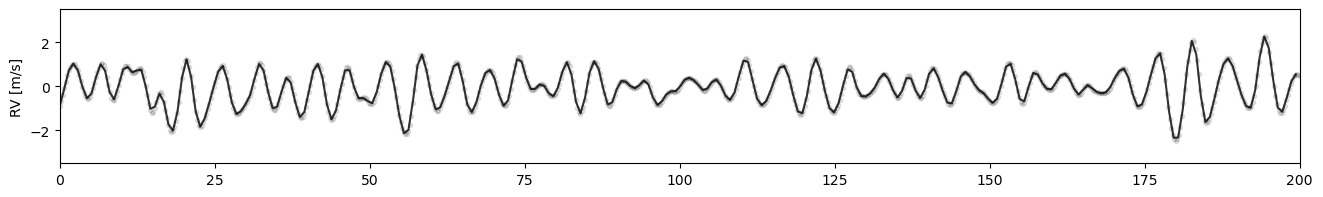

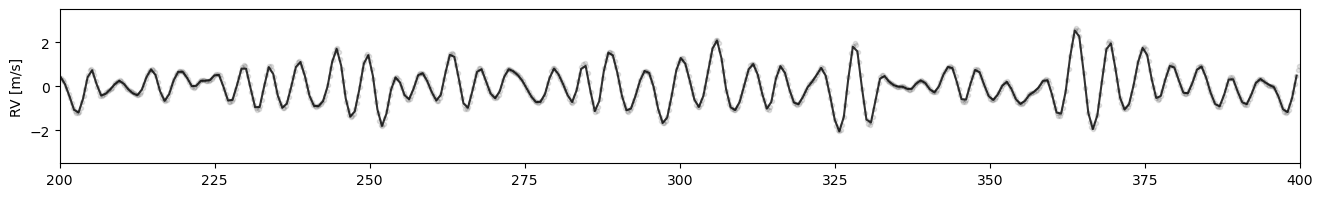

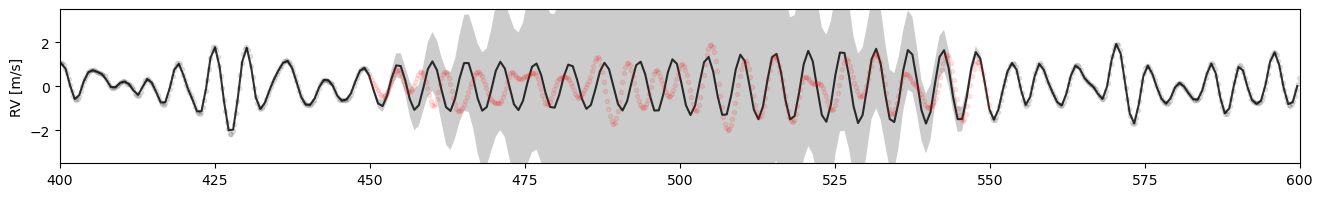

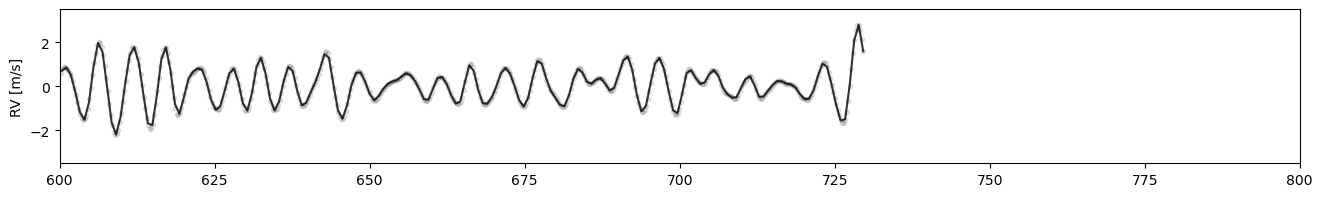

In [20]:
for i in range(4):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(x[idx_x], pred_mean[idx_x], color='k', alpha=0.8)
    plt.plot(t0[idx_test], y0[idx_test], '.', color='r', alpha=0.1)
    plt.fill_between(x[idx_x], pred_mean[idx_x]+pred_std[idx_x], pred_mean[idx_x]-pred_std[idx_x], color='k', alpha=0.2,
                     edgecolor="none")
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-3.5, 3.5])
    plt.show()

In [22]:
amp, mu, sig = np.array([ 5.46875972e-03,  3.08082489e+03, 3.05370933e+02])    
amp *= 6e1
nu_max = mu
delta_nu = 135
epsilon = 0
Q = 4e2

In [23]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    
    A1 = jnp.exp(theta["log_A1"])
    A2 = jnp.exp(theta["log_A2"])
    A3 = jnp.exp(theta["log_A3"])
    A4 = jnp.exp(theta["log_A4"])
    A5 = jnp.exp(theta["log_A5"])
    A6 = jnp.exp(theta["log_A6"])
    A7 = jnp.exp(theta["log_A7"])
    A8 = jnp.exp(theta["log_A8"])
    A9 = jnp.exp(theta["log_A9"])    
    # A3 = jnp.exp(theta["log_A3"])
    delta_nu =135
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    omega = 2*np.pi*(nu_max + (-3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A1)
    omega = 2*np.pi*(nu_max + (-2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A2)
    omega = 2*np.pi*(nu_max + (-1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A3)
    omega = 2*np.pi*(nu_max + (0)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A4)
    omega = 2*np.pi*(nu_max + (1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A5)
    omega = 2*np.pi*(nu_max + (2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A6)
    omega = 2*np.pi*(nu_max + (3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A7)
    omega = 2*np.pi*(nu_max + (-4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A8)    
    omega = 2*np.pi*(nu_max + (4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A9)    
    
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(300),
    "log_A1": np.log(0.5*amp),
    "log_A2": np.log(0.5*amp),
    "log_A3": np.log(0.5*amp),
    "log_A4": np.log(0.5*amp),
    "log_A5": np.log(0.5*amp),
    "log_A6": np.log(0.5*amp),
    "log_A7": np.log(0.5*amp),
    "log_A8": np.log(0.5*amp),
    "log_A9": np.log(0.5*amp),
    "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)



Initial negative log likelihood: 31159.41104584654
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(-7232.10680903, dtype=float64), 'log_A2': DeviceArray(-7592.08749832, dtype=float64), 'log_A3': DeviceArray(-8086.63458443, dtype=float64), 'log_A4': DeviceArray(-8676.26893098, dtype=float64), 'log_A5': DeviceArray(-9404.0033946, dtype=float64), 'log_A6': DeviceArray(-10321.05548468, dtype=float64), 'log_A7': DeviceArray(-11421.20019192, dtype=float64), 'log_A8': DeviceArray(-7001.27109438, dtype=float64), 'log_A9': DeviceArray(-12944.48369477, dtype=float64), 'log_Q': DeviceArray(41298.47798444, dtype=float64), 'log_nu_max': DeviceArray(-166397.23009695, dtype=float64)}


In [27]:
def solve():
    w_init = jnp.zeros(len(theta_init))
    lower_bounds = jnp.ones_like(w_init)* (-1)
    upper_bounds = jnp.ones_like(w_init) * jnp.inf
    bounds = (lower_bounds, upper_bounds)

    import jaxopt
    solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_likelihood)
    soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
    print(f"Final negative log likelihood: {soln.state.fun_val}")

    for key, value in soln.params.items():
        print(key[4:], np.exp(value))
    
    model_gp, _ = build_gp(soln.params, t)
    
    fig = plt.figure(figsize=(16, 6))
    # plt.plot(t, kernel(t, t[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
    plt.plot(t, model_gp.kernel(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
    plt.title('Kernels')
    plt.xlabel(r'$\Delta t$ [minutes]')
    plt.ylabel(r'Covariance [m$^2$/s$^2$]')
    plt.legend()
    plt.show()

Final negative log likelihood: -5735.5624075888245
A1 0.3678794411714424
A2 0.3678794411714424
A3 0.3678794411714424
A4 0.3678794411714424
A5 0.3678794411714424
A6 0.3678794411714424
A7 0.3678794411714424
A8 4.407811305626944
A9 4.00560526111721
Q 1578.6608590932153
nu_max 3097.1527379215586


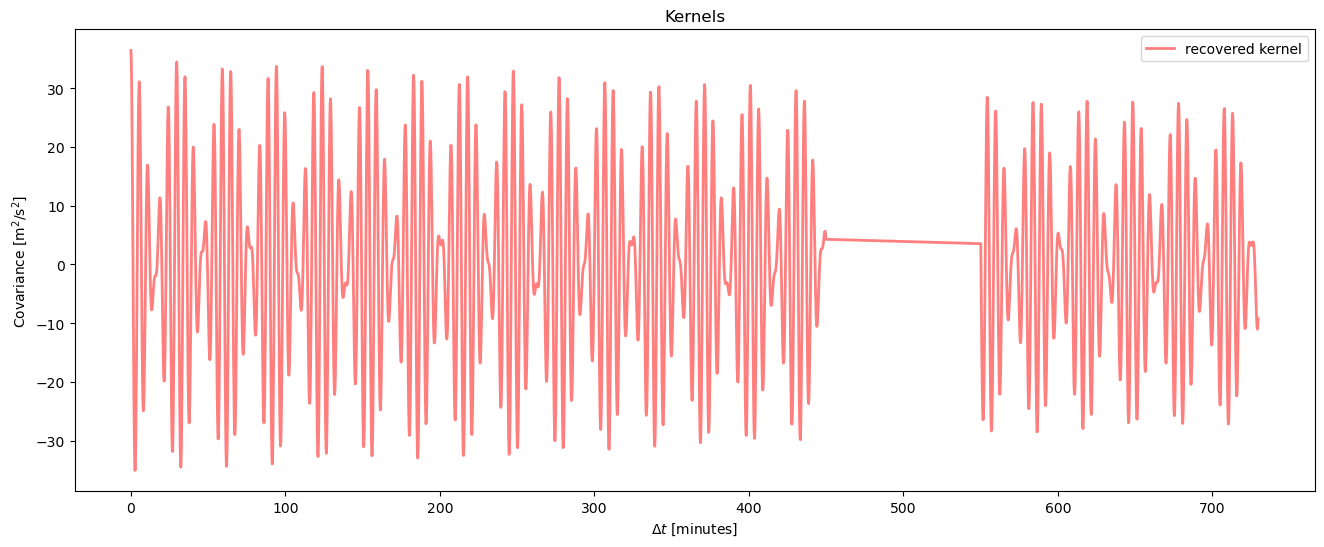

In [28]:
solve()

In [30]:
t.shape

(2589,)